# Francesca Bruno
# Webscraping Project Part 2
# 11/27/2024
# Webscraping Google Trends to answer data analysis questions relating to gaming trends in the past 7 days in the US, Canada, India, South Korea, and Japan.

In [1775]:
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
import time
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as p
import numpy as np
import seaborn as sb

# Because my original questions for part one of the project couldn't be used since they pertained to Linkedin which doesn't allow webscraping, I made new questions for Google Trends

## 1) How does total search volume in gaming trends compare between these countries? (Pie chart)
## 2) How does the average duration of gaming trends compare between the countries? (Bar chart)
## 3) How does the number of active gaming trends compare between these countries? (Bar chart)
## 4) What is the relationship between when a trend started and its search volume by country? (Scatter plots)

## Defining the functions needed to get the driver from Chrome and the raw trends data from the web page.

In [1779]:
def get_driver():
    # This is my path to the Chrome binary
    chromePath = "C:\\Program Files\\Google\\Chrome\\Application\\chrome.exe"
    options = Options()
    options.binary_location = chromePath
    driver = webdriver.Chrome(options=options)
    return driver

def get_raw_trends_data(driver: webdriver.Chrome, geo: str) -> str:
    url = f"https://trends.google.com/trending?geo={geo}&hl=en-US&hours=168&category=6"
    print(f"Getting data from {url}")
    driver.get(url)
    # Getting the url twice to get around the initial 429 error
    driver.get(url)
    driver.maximize_window()
    # Waiting for the page to finish loading
    time.sleep(5)
    return driver.page_source

## Scraping data for trends in the 'games' category in specific locations (These are the 5 pages)

In [1781]:
driver = get_driver()
# Gaming trends in the US in the past 7 days
raw_data_US = get_raw_trends_data(driver, "US")
# Gaming trends in Japan in the past 7 days
raw_data_JP = get_raw_trends_data(driver, "JP")
# Gaming trends in India in the past 7 days
raw_data_IN = get_raw_trends_data(driver, "IN")
# Gaming trends in South Korea in the past 7 days
raw_data_SK = get_raw_trends_data(driver, "KR")
# Gaming trends in Canada in the past 7 days
raw_data_CA = get_raw_trends_data(driver, "CA")

Getting data from https://trends.google.com/trending?geo=US&hl=en-US&hours=168&category=6
Getting data from https://trends.google.com/trending?geo=JP&hl=en-US&hours=168&category=6
Getting data from https://trends.google.com/trending?geo=IN&hl=en-US&hours=168&category=6
Getting data from https://trends.google.com/trending?geo=KR&hl=en-US&hours=168&category=6
Getting data from https://trends.google.com/trending?geo=CA&hl=en-US&hours=168&category=6


## Filtering through the source code for useful data
Search volume: class="lqv0Cb"

Trend that is still active: class="QxIiwc TUfb9d"

Duration of trend (Inactive): class="QxIiwc FTOQPb"

When a trend started: class="vdw3Ld"

### Method to get the search volume of every trend in the raw data

In [1784]:
def get_volume(code: str) -> list:
    soup = BeautifulSoup(code, "html.parser")
    rawList = soup.find_all("div", class_="lqv0Cb")
    volume = []
    for item in rawList:
        # Getting the number of searches from the code
        item2 = str(item)
        index = item2.index("+")
        volumeV = item2[20:index]
        # Replacing K and M with their actual numeric values (1K = 1000, 12M = 12000000)
        index2 = volumeV.find('K')
        if (index2 != -1):
            volumeV = volumeV[:index2] + "000"
        index2 = volumeV.find('M')
        if (index2 != -1):
            volumeV = volumeV[:index2] + "000000"
        # Adding the new clean value to the list
        volume.append(int(volumeV))
    return volume;

### Method to get the number of active trends

In [1786]:
def num_active(code: str) -> int:
    soup = BeautifulSoup(code, "html.parser")
    # This class only appears as part of the 'Active' label so the number of occurences of divs in this class is the number of active trends on the page
    rawList = soup.find_all("div", class_="QxIiwc TUfb9d")
    return len(rawList)

### Method to get the duration of any trends that have ended 
(active trends don't count because no one knows how long they will continue to go on for)

In [1788]:
def get_duration(code: str) -> list:
    soup = BeautifulSoup(code, "html.parser")
    rawList = soup.find_all("div", class_="QxIiwc FTOQPb")
    hoursList = []
    for item in rawList:
        # Cutting out the html parts so only the amount of time the trend lasted remains
        item2 = (str(item))[158:-12]
        # Removing the letter 's' so that 'days' can become 'day' which makes it easier to work with
        if (item2.find('days') != -1):
            item2.replace('days', 'day')
        # Analyzing the words in the string to calculate the number of hours the trend lasted for (ex: 1 day 4 hr 30 min -> 28.5)
        hours = 0.0
        index = item2.find('day')
        if (index != -1):
            hours += 24 * int(item2[:index])
            # Removing 'x day' from the string now that it's calculated
            item2 = item2[index+4:]
        index = item2.find('hr')
        if (index != -1):
            hours += int(item2[:index])
        index = item2.find('min')
        if (index != -1):
            hours += (int((item2[:index]))/60.0)   
        hoursList.append(hours)
    return hours

### Method to get when each trend started

In [1790]:
def get_start(code: str) -> list:
    soup = BeautifulSoup(code, "html.parser")
    rawList = soup.find_all("div", class_="vdw3Ld")
    startList = []
    for item in rawList:
        # Removing all of the html code other then the time started
        item = (str(item))[93:-6]
        hours = 0
        # 'yesterday' will assume '1 day ago' which is 24 hours ago
        if (item.find('yesterday') != -1):
            hours = 24
        # Analyzing the words in the string to calculate the number of hours ago the trend started (ex: 2 days ago -> 48)
        index = item.find('days')
        if (index != -1):
            hours = 24 * int(item[:index])
        index = item.find('hour')
        if (index != -1):
            hours = int(item[:index]) 
        index = item.find('min')
        if (index != -1):
            hours = (int((item[:index]))/60.0)
        startList.append(hours)
    return startList

## Getting the search volume of all gaming trends in the countries

In [1792]:
volume_CA = get_volume(raw_data_CA)
volume_US = get_volume(raw_data_US)
volume_IN = get_volume(raw_data_IN)
volume_JP = get_volume(raw_data_JP)
volume_SK = get_volume(raw_data_SK)

## Testing that the volumes are clean integers (No more '+', 'K', or 'M')

In [1794]:
print(volume_CA)
print(volume_US)
print(volume_IN)
print(volume_JP)
print(volume_SK)

[500000, 10000, 1000, 50000, 200, 5000, 5000, 1000, 2000, 50000, 1000, 2000, 500, 5000, 1000, 2000, 2000, 200, 1000, 200, 200, 1000, 1000, 200, 100]
[200000, 50000, 100000, 5000, 50000, 5000, 50000, 5000, 200, 5000, 50000, 20000, 50000, 2000, 2000, 5000, 5000, 2000, 2000, 10000, 5000, 5000, 5000, 1000, 2000]
[2000000, 5000, 20000, 50000, 20000, 2000, 20000, 5000, 5000, 2000, 20000, 2000, 10000, 5000, 10000, 500, 1000, 100, 1000, 1000, 2000, 2000, 2000, 500, 200]
[50000, 10000, 2000, 200000, 10000, 5000, 20000, 50000, 20000, 2000, 10000, 20000, 20000, 10000, 20000, 5000, 5000, 10000, 10000, 10000, 10000, 5000, 10000, 5000, 5000]
[20000, 200, 500, 2000, 200, 200, 1000, 500, 1000, 1000, 5000, 1000, 2000, 500, 1000, 1000, 2000, 500, 100, 500, 100]


## Getting the number of active gaming trends in the countries

In [1796]:
num_active_US = num_active(raw_data_US)
num_active_CA = num_active(raw_data_CA)
num_active_JP = num_active(raw_data_JP)
num_active_IN = num_active(raw_data_IN)
num_active_SK = num_active(raw_data_SK)

## Getting the duration of any trends that have ended

In [1798]:
duration_US = get_duration(raw_data_US)
duration_CA = get_duration(raw_data_CA)
duration_IN = get_duration(raw_data_IN)
duration_JP = get_duration(raw_data_JP)
duration_SK = get_duration(raw_data_SK)
# I did check that the data cleaning works with print statments but keeping it here would require a print statement on every iteration of the loop and would use a lot of space

## Getting how long ago each trend started

In [1800]:
start_US = get_start(raw_data_US)
start_CA = get_start(raw_data_CA)
start_IN = get_start(raw_data_IN)
start_JP = get_start(raw_data_JP)
start_SK = get_start(raw_data_SK)

## Testing to see if the data was cleaned for start time and converted into hours

In [1802]:
print(start_US)

[24, 120, 120, 11, 24, 5, 48, 7, 0.5, 13, 1, 96, 120, 12, 24, 96, 120, 24, 48, 144, 72, 72, 120, 24, 72]


## Creating the dataframe with all of the info by country

In [1804]:
df = pd.DataFrame({"Country":["United States", "Canada", "Japan", "India", "South Korea"], "TotalSearchVolume":[sum(volume_US), sum(volume_CA), sum(volume_JP), sum(volume_IN), sum(volume_SK)], "SearchVolume":[volume_US, volume_CA, volume_JP, volume_IN, volume_SK], "ActiveTrends":[num_active_US, num_active_CA, num_active_JP, num_active_IN, num_active_SK], "TrendDuration":[duration_US, duration_CA, duration_JP, duration_IN, duration_SK], "AverageDuration":[np.mean(duration_US), np.mean(duration_CA), np.mean(duration_JP), np.mean(duration_IN), np.mean(duration_SK)]})

## 1) How does total search volume in gaming trends compare between these countries?

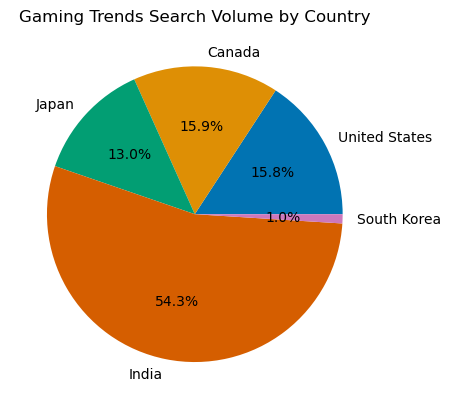

In [1806]:
palette_color = sb.color_palette('colorblind') 
df.plot.pie(y='TotalSearchVolume', labels=df['Country'], autopct='%1.1f%%', ylabel = '', legend = False, colors=palette_color)
p.title('Gaming Trends Search Volume by Country')
p.show()

### India has the overwhelming majority of all game trend searches, with the rest of the share of searches split evenly between the remaining countries other then South Korea which has a notably low share. (As of 11/27/2024)

## 2) How does the average duration of gaming trends compare between the countries? (Bar chart)

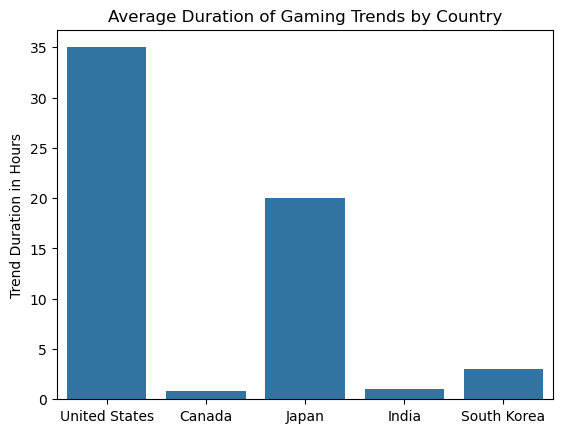

In [1808]:
sb.barplot(data = df, x='Country', y='AverageDuration')
p.title("Average Duration of Gaming Trends by Country")
p.ylabel('Trend Duration in Hours')
p.xlabel("")
p.show()

### Running this visualization mutliple times throughout the day yielded a wide variety of results due to the dynamic nature of Google Trends.

## 3) How does the number of active gaming trends compare between these countires? (Bar chart)

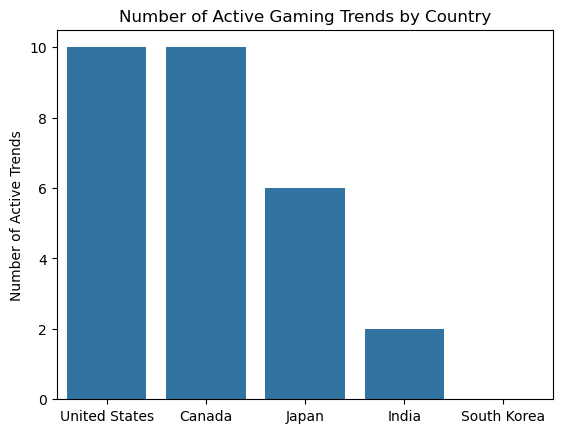

In [1810]:
sb.barplot(data = df, x='Country', y='ActiveTrends')
p.title("Number of Active Gaming Trends by Country")
p.xlabel('')
p.ylabel('Number of Active Trends')
p.show()

### Running this visualization mutliple times throughout the day yielded a wide variety of results due to the dynamic nature of Google Trends.

## 4) What is the relationship between when a trend started and its search volume by country? (Scatter plot)

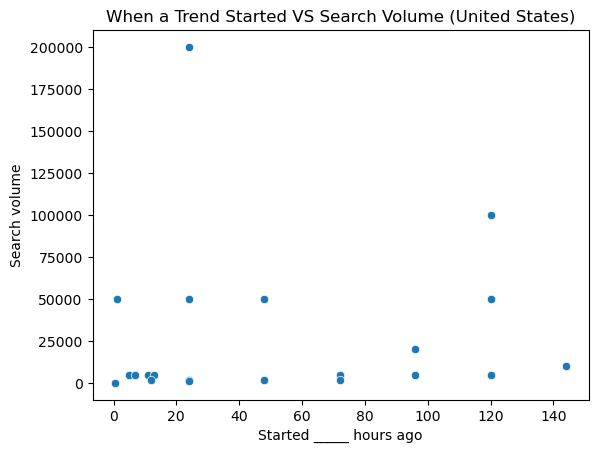

In [1812]:
sb.scatterplot(x = start_US, y = volume_US)
p.xlabel("Started _____ hours ago")
p.ylabel("Search volume")
p.title("When a Trend Started VS Search Volume (United States)")
p.show()

### Running this visualization mutliple times throughout the day yielded a wide variety of results due to the dynamic nature of Google Trends.

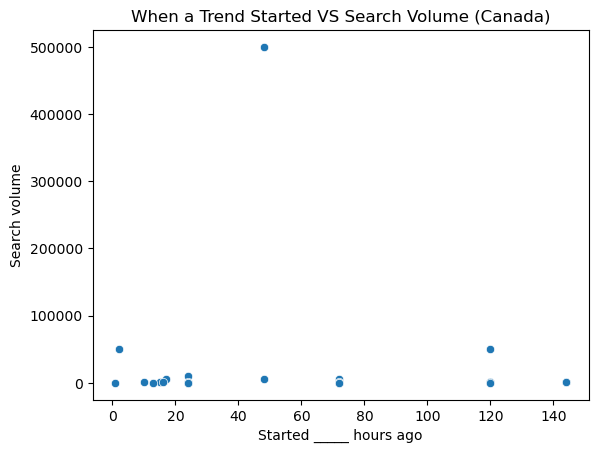

In [1813]:
sb.scatterplot(x = start_CA, y = volume_CA)
p.xlabel("Started _____ hours ago")
p.ylabel("Search volume")
p.title("When a Trend Started VS Search Volume (Canada)")
p.show()

### Running this visualization mutliple times throughout the day yielded a wide variety of results due to the dynamic nature of Google Trends.

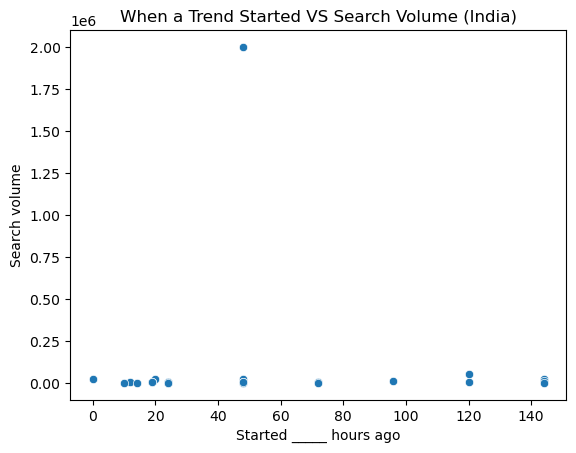

In [1814]:
sb.scatterplot(x = start_IN, y = volume_IN)
p.xlabel("Started _____ hours ago")
p.ylabel("Search volume")
p.title("When a Trend Started VS Search Volume (India)")
p.show()

### Running this visualization mutliple times throughout the day yielded a wide variety of results due to the dynamic nature of Google Trends.

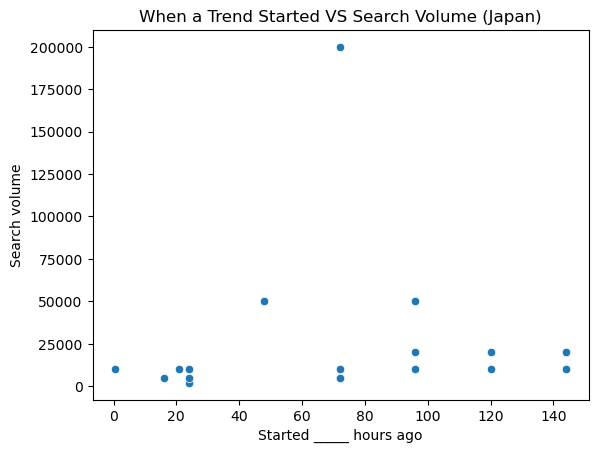

In [1815]:
sb.scatterplot(x = start_JP, y = volume_JP)
p.xlabel("Started _____ hours ago")
p.ylabel("Search volume")
p.title("When a Trend Started VS Search Volume (Japan)")
p.show()

### Running this visualization mutliple times throughout the day yielded a wide variety of results due to the dynamic nature of Google Trends.

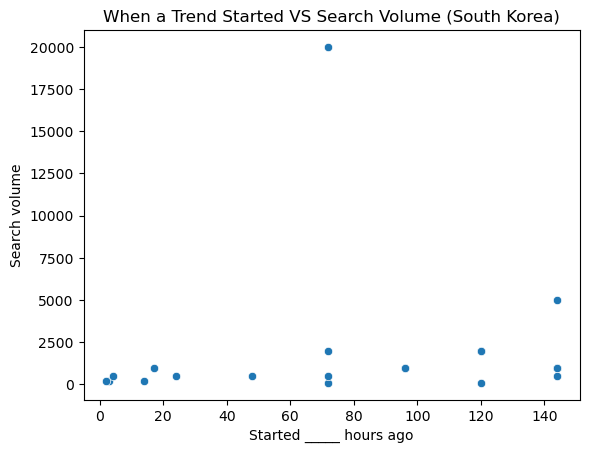

In [1816]:
sb.scatterplot(x = start_SK, y = volume_SK)
p.xlabel("Started _____ hours ago")
p.ylabel("Search volume")
p.title("When a Trend Started VS Search Volume (South Korea)")
p.show()

### Running this visualization mutliple times throughout the day yielded a wide variety of results due to the dynamic nature of Google Trends.